# Exercise 3 — Los Angeles highway network (traffic.mat etc.)

In [102]:
import numpy as np
import scipy.io as sio
import networkx as nx
import matplotlib.pyplot as plt


B = sio.loadmat('traffic.mat')['traffic']
c = sio.loadmat('capacities.mat')['capacities'].reshape(-1,)
l = sio.loadmat('traveltime.mat')['traveltime'].reshape(-1,)
f_given = sio.loadmat('flow.mat')['flow'].reshape(-1,)


num_nodes, m = B.shape

print(f"Loaded: B in R^{B.shape}, capacities c in R^{c.shape}, times l in R^{l.shape}, flow f in R^{f_given.shape}")


# 2) Sanity checks on data & indices

problems = []

# Incidence matrix checks:
# - entries are in {-1,0,1}
# - each column has exactly one +1 and one -1 (directed arc tail->head)
if not np.all(np.isin(B, [-1,0,1])):
    problems.append("B has entries outside {-1,0,1}.")

col_sums = B.sum(axis=0)
if not np.all(col_sums == 0):
    problems.append("Some columns of B do not sum to zero.")

pos_counts = (B == 1).sum(axis=0)
neg_counts = (B == -1).sum(axis=0)
if not np.all(pos_counts == 1) or not np.all(neg_counts == 1):
    problems.append("Each column of B must have exactly one +1 (tail) and one -1 (head).")

# Sizes
if not (c.shape[0] == m and l.shape[0] == m):
    problems.append("Lengths of c or l do not match number of columns in B.")

# Nonnegativity & finiteness
if np.any(~np.isfinite(c)) or np.any(~np.isfinite(l)):
    problems.append("c or l contains non-finite values (inf/NaN).")
if np.any(c < 0):
    problems.append("Capacities must be nonnegative.")
if np.any(l < 0):
    problems.append("Free-flow travel times l must be nonnegative.")

if f_given is not None:
    if f_given.shape[0] != m:
        problems.append("Length of f (flow) does not match number of columns in B.")
    if np.any(~np.isfinite(f_given)):
        problems.append("f contains non-finite values (inf/NaN).")
    if np.any(f_given < -1e-5):
        problems.append("Flow must be nonnegative (within tolerance).")
   
# Print sanity report
print("\n=== Sanity checks ===")
if problems:
    for p in problems:
        print("•", p)
else:
    print("All basic checks passed ✓")




Loaded: B in R^(17, 28), capacities c in R^(28,), times l in R^(28,), flow f in R^(28,)

=== Sanity checks ===
All basic checks passed ✓


# Summarized table of the network

In [103]:
import numpy as np
import pandas as pd

def edges_from_incidence(B, one_based=True, tail_sign=+1):
    """
    Extract directed edges (tail -> head) from incidence matrix B.

    Convention:
      tail_sign = +1  => tail has +1, head has -1  
    """
    B = np.asarray(B)
    tails, heads = [], []
    for j in range(B.shape[1]):
        col = B[:, j]

        if tail_sign == +1:
            tail_idx = np.where(col == +1)[0]
            head_idx = np.where(col == -1)[0]
        else:  # tail_sign == -1
            tail_idx = np.where(col == -1)[0]
            head_idx = np.where(col == +1)[0]

        tail = int(tail_idx[0]) if tail_idx.size else np.nan
        head = int(head_idx[0]) if head_idx.size else np.nan

        if one_based:
            if not np.isnan(tail): tail += 1
            if not np.isnan(head): head += 1

        tails.append(tail)
        heads.append(head)

    return np.array(tails), np.array(heads)

tails, heads = edges_from_incidence(B, one_based=True, tail_sign=+1)

m = B.shape[1]  # number of edges

df = pd.DataFrame({
    "edge_id": np.arange(1, m + 1),
    "from": tails,
    "to": heads,
    "capacity": c.astype(float),
    "flow": f_given.astype(float),
    "travel_time": l.astype(float),
})

# Derived metrics (optional)
df["utilization"] = df["flow"] / df["capacity"]
df["spare_capacity"] = df["capacity"] - df["flow"]

# Pretty formatting
df_fmt = df.copy()
df_fmt["utilization"] = (100*df["utilization"]).round(1).astype(str) + "%"

print("\n=== Network Edge Summary (tail = +1, head = -1) ===")
print(df_fmt.to_string(index=False))



=== Network Edge Summary (tail = +1, head = -1) ===
 edge_id  from  to  capacity    flow  travel_time utilization  spare_capacity
       1     1   2    8741.0  7524.0     0.162100       86.1%          1217.0
       2     2   3    9864.0  6537.0     0.055400       66.3%          3327.0
       3     3   4   13350.0 11139.0     0.129000       83.4%          2211.0
       4     4   5   10926.0  9282.0     0.186670       85.0%          1644.0
       5     1   6   13707.0  9282.0     0.129830       67.7%          4425.0
       6     6   7    6960.0  6398.0     0.078333       91.9%           562.0
       7     7   8    7422.0  6728.0     0.094000       90.6%           694.0
       8     8   9    6678.0  5988.0     0.057333       89.7%           690.0
       9     9  13    6297.0  5951.0     0.141670       94.5%           346.0
      10     2   7   11102.0  9557.0     0.105170       86.1%          1545.0
      11     3   8    8899.0  7423.0     0.106670       83.4%          1476.0
      12   

# Network plot 


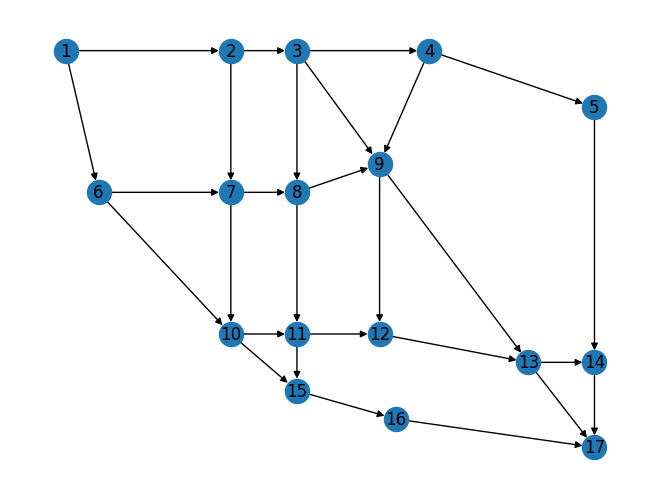

In [96]:
import numpy as np
#Create the graph from B

G = nx.DiGraph()
edges = []
m,n = B.shape
for e in range(n):
    u,v = 0,0
    for i in range(m):
        if B[i][e] == 1:
            u = i
        elif B[i][e] == -1:
            v = i
    edges.append((u+1,v+1))

G.add_edges_from(edges)
pos = {1:[0,0],2:[5,0],3:[7,0],4:[11,0],5:[16,-2],6:[1,-5],7:[5,-5],8:[7,-5],9:[9.5,-4],10:[5,-10],11:[7,-10],12:[9.5,-10],13:[14,-11],14:[16,-11],15:[7,-12],16:[10,-13],17:[16,-14]}
nx.draw(G,pos,with_labels=True)


# Part 3(a) Shortest (fastest when empty) path from node 1 to 17

In free flow, each link’s travel time is 𝑙𝑒. The fastest path problem is a standard shortest path on a weighted directed graph with weights 𝑙𝑒.

In [107]:
import networkx as nx

# Build directed graph with edge weights l_e
G = nx.DiGraph()
for e in range(m):
    # From B's column e, find tail (row with +1) and head (row with -1)
    tail = int(np.where(B[:,e]== 1)[0][0]) + 1   # +1 to match node labels 1..17
    head = int(np.where(B[:,e]==-1)[0][0]) + 1
    G.add_edge(tail, head, weight=float(l[e]), eid=e)

# Shortest path by travel time
path_nodes = nx.shortest_path(G, source=1, target=17, weight='weight')
path_cost  = nx.shortest_path_length(G, source=1, target=17, weight='weight')
print("Fastest path (empty network):", path_nodes)
print("Total free-flow time:", path_cost)


Fastest path (empty network): [1, 2, 3, 9, 13, 17]
Total free-flow time: 0.559833


# Part 3(b) Maximum flow from 1 to 17

Max-flow with capacities 𝑐𝑒 on each arc; source = 1, sink = 17.

In [109]:
# Build capacity graph
Gc = nx.DiGraph()
for e in range(m):
    tail = int(np.where(B[:,e]== 1)[0][0]) + 1
    head = int(np.where(B[:,e]==-1)[0][0]) + 1
    Gc.add_edge(tail, head, capacity=float(c[e]), eid=e)

flow_value, flow_dict = nx.maximum_flow(Gc, 1, 17, capacity='capacity')
print("Maximum s–t flow (1→17):", flow_value)


# check via min cut theorem

cut_value, partition = nx.minimum_cut(Gc, 1, 17)

S, T = partition  # unpack the two node sets

print(f"Minimum cut value: {cut_value:.2f}")
print(f"Set S (source side): {sorted(S)}")
print(f"Set T (sink side): {sorted(T)}")


Maximum s–t flow (1→17): 22448.0
Minimum cut value: 22448.00
Set S (source side): [1]
Set T (sink side): [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


# Part 3(c) Compute node balance ν = B@f 
i.e positive entries = net inflow (sources), negative = net outflow (sinks), zero for others.

In [110]:
nu = B @ f_given
print("nu = B f_given =", nu)

# We will use a “canonical” OD setting: only node 1 injects and node 17 absorbs
# (as the text specifies next), so set:
nu_star = np.zeros_like(nu)
nu_star[0]  = nu[0]     # node 1 (index 0) injects
nu_star[16] = -nu[0]    # node 17 (index 16) absorbs
print("nu* used in (d)–(g):", nu_star)


nu = B f_given = [ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]
nu* used in (d)–(g): [ 16806      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0 -16806]


# Part 3(d) Social optimum f*


In [140]:
import numpy as np
import cvxpy as cp

c = np.asarray(c, dtype=float)
l = np.asarray(l, dtype=float)
m = B.shape[1]
eps = 1e-6  # domain margin so 1 - f/c >= eps/c > 0

# Social optimum: minimize sum_e f_e * tau_e(f_e)
f_so = cp.Variable(m)
constraints_so = [B @ f_so == nu_star, f_so >= 0, f_so <= (c - eps)]
one_minus_so = 1 - cp.multiply(1/c, f_so)
obj_so = cp.sum(cp.multiply(l*c, cp.inv_pos(one_minus_so))) - float(np.sum(l*c))  # WITH constant
prob_so = cp.Problem(cp.Minimize(obj_so), constraints_so)
val_so = prob_so.solve(solver=cp.SCS, eps=1e-7, max_iters=100000, verbose=False)
f_star = f_so.value

# Compute TTT at social optimum 
tau_star = l / (1 - f_star/c)
TTT_star = float(np.sum(f_star * tau_star))

print("Social optimum flow f*:", f_star)
print("Social optimum objective  =", val_so)
print("TTT at social optimum =", TTT_star)


Social optimum flow f*: [ 6.53437100e+03  5.79454954e+03  3.04089049e+03  3.04089049e+03
  1.02716290e+04  4.69084601e+03  3.06781792e+03  2.57927070e+03
  3.09952789e+03  7.39821461e+02  2.85453905e-07  2.75365906e+03
  1.40834403e-07  3.04089049e+03  5.58078299e+03  2.88988991e+03
  5.05374262e+03  2.36284955e+03  4.88547227e+02  2.23340186e+03
  3.37843714e+03  5.61183900e+03  2.37324132e+03 -3.15018079e-07
  6.33812558e+03  5.41413180e+03  5.05374262e+03  5.05374262e+03]
Social optimum objective  = 26145.183288809956
TTT at social optimum = 26145.183288809967


# Part 3(e) Wardrop equilibrium f(0) (selfish routing)

Wardrop equilibrium minimizes the Beckmann potential and the KKT conditions ensure all used s–t paths have equal minimal travel time.

In [115]:
# Wardrop (Beckmann potential)
f_w = cp.Variable(m)
constraints_w = [B @ f_w == nu_star, f_w >= 0, f_w <= (c - eps)]
one_minus_w = 1 - cp.multiply(1/c, f_w)
obj_w = cp.sum(- cp.multiply(l*c, cp.log(one_minus_w)))   # Beckmann potential
prob_w = cp.Problem(cp.Minimize(obj_w), constraints_w)
val_w = prob_w.solve(solver=cp.SCS, eps=1e-7, max_iters=100000, verbose=False)
f_wardrop = f_w.value

# Compute TTT at Wardrop 
tau_w = l / (1 - f_wardrop/c)
TTT_w = float(np.sum(f_wardrop * tau_w))

print("\nWardrop flow f^0:", f_wardrop)
print("Beckmann objective =", val_w)
print("TTT at Wardrop =", TTT_w)

# Price of Anarchy can't be less than 1
PoA = TTT_w / TTT_star
print("\nPrice of Anarchy (TTT_w / TTT_star) =", PoA)



Wardrop flow f^0: [ 6.45711087e+03  6.25929219e+03  2.19489710e+03  2.19489710e+03
  1.03488891e+04  4.74508109e+03  2.85853642e+03  2.23862562e+03
  3.34479442e+03  1.97818684e+02  2.07709473e-01  4.06418738e+03
  2.00566268e-07  2.19489710e+03  5.60380804e+03  2.35825376e+03
  5.32991764e+03  2.08436335e+03  6.20118505e+02  2.95801858e+03
  2.97837226e+03  5.93639084e+03  2.52813281e+03 -4.75979497e-07
  6.75305246e+03  4.72302991e+03  5.32991763e+03  5.32991763e+03]
Beckmann objective = 15734.703005790874
TTT at Wardrop = 26510.422674731282

Price of Anarchy (TTT_w / TTT_star) = 1.0139696624761332


# Part 3(f) Pigouvian tolls and Wardrop with tolls

To align selfish behavior with the social optimum, charge tolls

In [139]:
import numpy as np
import cvxpy as cp

c = np.asarray(c, dtype=float)
l = np.asarray(l, dtype=float)
m = B.shape[1]

# Use a slightly bigger margin to avoid log(1 - f/c) near zero
eps = 1e-5

# Social optimum (3d): minimize sum f_e τ_e(f_e) 
f_so = cp.Variable(m)
cons_so = [B @ f_so == nu_star, f_so >= 0, f_so <= (c - eps)]
one_minus_so = 1 - cp.multiply(1/c, f_so)
obj_so = cp.sum(cp.multiply(l*c, cp.inv_pos(one_minus_so))) - float(np.sum(l*c))

prob_so = cp.Problem(cp.Minimize(obj_so), cons_so)

val_so = prob_so.solve(solver=cp.SCS, eps=1e-7, max_iters=200000, verbose=False, warm_start=True)

f_star = f_so.value
f_star = np.clip(f_star, 0, c - 1e-9)

# ¡ Build Pigouvian tolls ω = f* τ'(f*) 
def tau_prime(f, le, ce):
    x = f/ce
    return (le/ce) / (1 - x)**2

omega = f_star * tau_prime(f_star, l, c)


# Wardrop with tolls (3f): Beckmann + ω f
f_toll = cp.Variable(m)
cons_tl = [B @ f_toll == nu_star, f_toll >= 0, f_toll <= (c - eps)]
one_minus_tl = 1 - cp.multiply(1/c, f_toll)
beckmann = - cp.multiply(l*c, cp.log(one_minus_tl))
toll_lin = cp.multiply(omega, f_toll)
obj_tl = cp.sum(beckmann + toll_lin)
prob_tl = cp.Problem(cp.Minimize(obj_tl), cons_tl)

# Warm-start near f* to help solver land in the right basin
f_toll.value = f_star.copy()

val_tl = prob_tl.solve(solver=cp.SCS, eps=1e-7, max_iters=300000, verbose=False, warm_start=True)

f_wardrop_toll = f_toll.value

# ---------- (4) Diagnostics ----------

l1_gap = float(np.linalg.norm(f_wardrop_toll - f_star, 1))
cons_gap_so = float(np.linalg.norm(B @ f_star - nu_star, 1))
cons_gap_tl = float(np.linalg.norm(B @ f_wardrop_toll - nu_star, 1))
domain_gap = float(np.min(c - f_wardrop_toll))

print("||f(ω) - f*||₁ =", l1_gap)
print("||B f* - nu||₁ =", cons_gap_so, "   ||B f(ω) - nu||₁ =", cons_gap_tl)
print("min(c - f(ω)) =", domain_gap)


# Optional: compare TTTs to verify alignment
tau_star = l / (1 - f_star/c)
tau_toll = l / (1 - f_wardrop_toll/c)
TTT_star = float(np.sum(f_star * tau_star))
TTT_toll = float(np.sum(f_wardrop_toll * tau_toll))
print("TTT social =", TTT_star, "  TTT(w/tolls) =", TTT_toll)

# Price of Anarchy can't be less than 1
PoA = TTT_toll / TTT_star
print("\nPrice of Anarchy (TTT_w / TTT_star) =", PoA)


||f(ω) - f*||₁ = 85.87016499759201
||B f* - nu||₁ = 4.1535815760719886e-09    ||B f(ω) - nu||₁ = 4.039626457244903e-10
min(c - f(ω)) = 2163.3229848233204
TTT social = 26142.67379580966   TTT(w/tolls) = 26142.82266195681

Price of Anarchy (TTT_w / TTT_star) = 1.0000056943734337


# Part 3(g) Alternative system cost: total additional travel time


In [138]:
import numpy as np
import cvxpy as cp

c = np.asarray(c, dtype=float)
l = np.asarray(l, dtype=float)
m = B.shape[1]

# Keep a comfortable margin away from f=c to stabilize log/inv
eps = 1e-5

# tau'(f) for tau(f) = l / (1 - f/c)
def tau_prime(f, le, ce):
    x = f / ce
    return (le / ce) / (1 - x)**2

# System optimum for "additional travel time
# Minimize sum_e [ l*c/(1 - f/c) - l*c - l*f ]
f_add = cp.Variable(m)
cons_add = [B @ f_add == nu_star, f_add >= 0, f_add <= (c - eps)]

one_minus_add = 1 - cp.multiply(1/c, f_add)
# elementwise: l*c*inv_pos(1 - f/c) - l*c - l*f
obj_add = cp.sum( cp.multiply(l*c, cp.inv_pos(one_minus_add)) - (l*c) - cp.multiply(l, f_add) )

prob_add = cp.Problem(cp.Minimize(obj_add), cons_add)
val_add = prob_add.solve(solver=cp.SCS, eps=1e-7, max_iters=300000, verbose=False, warm_start=True)

f_star_add = f_add.value

print("System optimum (additional TT) f* obtained.",f_star_add)
print("Objective (additional TT) =", float(val_add))

# Pigouvian tolls for additional TT 
# ω* = f* τ'(f*) - l
omega_star = f_star_add * tau_prime(f_star_add, l, c) - l

# ---------- (3) Wardrop with ω*: minimize Beckmann + ω*^T f ----------
fW_star = cp.Variable(m)
cons_Ws = [B @ fW_star == nu_star, fW_star >= 0, fW_star <= (c - eps)]

one_minus_Ws = 1 - cp.multiply(1/c, fW_star)
beckmann = - cp.multiply(l*c, cp.log(one_minus_Ws))   # ∑ -l c log(1 - f/c)
toll_lin = cp.multiply(omega_star, fW_star)           # ∑ ω* f
obj_Ws = cp.sum(beckmann + toll_lin)

prob_Ws = cp.Problem(cp.Minimize(obj_Ws), cons_Ws)

# Warm-start at f*_add helps the solver converge to the intended solution
fW_star.value = f_star_add.copy()

val_Ws = prob_Ws.solve(solver=cp.SCS, eps=1e-7, max_iters=300000, verbose=False, warm_start=True)

f_wardrop_star = fW_star.value

# ---------- (4) Diagnostics ----------
l1_gap = float(np.linalg.norm(f_wardrop_star - f_star_add, 1))
cons_gap_add = float(np.linalg.norm(B @ f_star_add - nu_star, 1))
cons_gap_ws  = float(np.linalg.norm(B @ f_wardrop_star - nu_star, 1))
domain_gap   = float(np.min(c - f_wardrop_star))

print("\nWardrop with ω* completed.", fW_star.value)
print("||f(ω*) - f*_add||₁ =", l1_gap)
print("||B f*_add - nu||₁ =", cons_gap_add, "   ||B f(ω*) - nu||₁ =", cons_gap_ws)
print("min(c - f(ω*)) =", domain_gap)



# Compare the "additional travel time" objective values directly for both flows
def additional_TT_value(fvec, l, c):
    return float(np.sum( l*c/(1 - fvec/c) - l*c - l*fvec ))


# (Optional) also compare total TTTs if you want:
def total_TT_value(fvec, l, c):
    tau = l / (1 - fvec/c)
    return float(np.sum(fvec * tau))

TTT_add = total_TT_value(f_star_add, l, c)
TTT_ws  = total_TT_value(f_wardrop_star, l, c)

# Price of Anarchy can't be less than 1
PoA = TTT_ws / TTT_add
print("\nPrice of Anarchy =", PoA)


System optimum (additional TT) f* obtained. [6.55206646e+03 5.57873468e+03 3.37315776e+03 3.37315776e+03
 1.02539335e+04 4.69155907e+03 3.16546132e+03 2.73192660e+03
 3.00937849e+03 9.73331785e+02 5.58283156e-08 2.20557692e+03
 2.09428936e-07 3.37315776e+03 5.56237446e+03 3.10961149e+03
 4.95219251e+03 2.49942954e+03 4.33534716e+02 1.92812504e+03
 3.54314621e+03 5.47127124e+03 2.22970242e+03 2.71680156e-07
 6.25094731e+03 5.60286018e+03 4.95219251e+03 4.95219251e+03]
Objective (additional TT) = 15353.199698611206

Wardrop with ω* completed. [6.78988206e+03 5.58929663e+03 3.34842469e+03 3.34842469e+03
 1.00161179e+04 4.52677187e+03 3.12177450e+03 2.64285431e+03
 2.92385868e+03 1.20058543e+03 4.89819757e-10 2.24087194e+03
 8.72464952e-10 3.34842469e+03 5.48934607e+03 2.99551530e+03
 5.09941357e+03 2.60558280e+03 4.78920189e+02 1.95986758e+03
 3.47443549e+03 5.43430307e+03 2.10617810e+03 7.98157554e-10
 6.25198365e+03 5.45460278e+03 5.09941357e+03 5.09941357e+03]
||f(ω*) - f*_add||₁ = 239